In [1]:
import os
import json

os.chdir('../../')

In [2]:
import torch
from rdkit import Chem
import numpy as np
from itertools import chain
from rdkit.Chem import DataStructs
from rdkit.Chem import Draw

/home/tsa87/anaconda3/envs/tacogfn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [72]:
pharmaco_res_path = 'misc/evaluations/archive/20240117_alpha_default_evaluated.json'
with open(pharmaco_res_path) as f:
    pharmaco_res = json.load(f)

In [73]:
decomp_res_path = 'misc/evaluations/decompdiff_agg_data_evaluated.json'
with open(decomp_res_path) as f:
    decomp_res = json.load(f)

In [74]:
crossdock = torch.load(
    "dataset/archived/crossdock_docking_scores/all_crossdock_100k.pt"
)
crossdock_smiles = list(set([v[1] for v in crossdock]))
crossdock_mols = [Chem.MolFromSmiles(s) for s in crossdock_smiles]
crossdock_fps = [Chem.RDKFingerprint(m) for m in crossdock_mols]

def get_most_similar_compound(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = Chem.RDKFingerprint(mol)
    s = DataStructs.BulkTanimotoSimilarity(fp, crossdock_fps)
    
    most_sim_i = s.index(max(s))
    return crossdock_smiles[most_sim_i]

In [75]:
all_decomp_nov = list(chain.from_iterable([v['novelty'] for v in decomp_res.values()]))

In [76]:
decomp_res.keys()

dict_keys(['4rn0_B', '3daf_A', '2v3r_A', '4pxz_A', '1fmc_B', '3ej8_A', '5tjn_A', '1d7j_A', '4qlk_A', '3pnm_A', '3jyh_A', '4rv4_A', '3g51_A', '2z3h_A', '5ngz_A', '1h0i_A', '4p6p_A', '2hcj_B', '5q0k_A', '5bur_A', '4q8b_B', '2e6d_A', '1phk_A', '14gs_A', '5aeh_A', '4xli_B', '4gvd_A', '3u9f_C', '4aaw_A', '4iiy_A', '1gg5_A', '2zen_A', '1jn2_P', '1r1h_A', '5mgl_A', '4rlu_A', '2rma_A', '1l3l_A', '1k9t_A', '4aua_A', '4zfa_A', '2jjg_A', '2f2c_B', '3v4t_A', '2gns_A', '4tos_A', '1afs_A', '3tym_A', '5mma_A', '2pc8_A', '4g3d_B', '4yhj_A', '3gs6_A', '3li4_A', '5i0b_A', '3kc1_A', '4iwq_A', '4kcq_A', '3l3n_A', '5w2g_A', '3u5y_B', '5d7n_D', '5liu_X', '4bel_A', '4d7o_A', '4u5s_A', '1h36_A', '1ai4_A', '4azf_A', '5l1v_A', '2azy_A', '1umd_B', '1djy_A', '4tqr_A', '1e8h_A', '2cy0_A', '3w83_B', '4f1m_A', '3chc_B', '4z2g_A', '3dzh_A', '4keu_A', '1dxo_C', '5b08_A', '3pdh_A', '2pqw_A', '1a2g_A', '4ja8_B', '3hy9_B', '4lfu_A', '2e24_A', '1rs9_A', '4m7t_A', '3o96_A', '3nfb_A', '3af2_A', '3b6h_A', '4h3c_A', '2rhy_A',

In [77]:
# Good ones '3daf_A' 
# pocket =  '3daf_A'

In [78]:
# pocket =  '4rv4_A'
# idx_sort = [i for i in np.argsort(decomp_res[pocket]['novelty']) if decomp_res[pocket]['docking_scores'][i] > -7 and decomp_res[pocket]['novelty'][i] > 0.05]

In [104]:
def try_pocket(pocket, save=False):
    #   and 
    print(pocket)
    #  decomp_res[pocket]['docking_scores'][i] > -8 and
    idx_sort = [i for i in np.argsort(decomp_res[pocket]['novelty']) if decomp_res[pocket]['novelty'][i] > 0.05]
    if len(idx_sort) == 0:
        return None
    i = 0
    
    print(f"novelty: {decomp_res[pocket]['novelty'][idx_sort[i]]}")
    print(f"qed: {decomp_res[pocket]['qeds'][idx_sort[i]]}")
    print(f"sa: {decomp_res[pocket]['sas'][idx_sort[i]]}")
    print(f"ds: {decomp_res[pocket]['docking_scores'][idx_sort[i]]}")

    decomp_diffmol = Chem.MolFromSmiles(decomp_res[pocket]['smiles'][idx_sort[i]])

    img = Draw.MolToImage(decomp_diffmol, size=(200, 133), thickness=0)
    if save:
        img.save('figures/example_mols/decomp_molecule1.png')
    
    smi = get_most_similar_compound(decomp_res[pocket]['smiles'][idx_sort[i]])
    sim_mol = Chem.MolFromSmiles(smi)

    img2 = Draw.MolToImage(sim_mol, size=(200, 133), thickness=0)
    if save:
        img2.save('figures/example_mols/decomp_similar_molecule1.png')
    
    return Draw.MolsToGridImage([decomp_diffmol, sim_mol], molsPerRow=2, subImgSize=(200, 133), useSVG=True), decomp_diffmol, sim_mol

In [193]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import cairosvg
import io


def molecule_to_svg(mol, file_name, width=300, height=300):

    # Define full path name
    full_path = f"figures/example_mols/{file_name}.svg"

    # Render high resolution molecule
    drawer = rdMolDraw2D.MolDraw2DSVG(width, height)
    drawer.drawOptions().bondLineWidth = 2 # Set the bond line width
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()

    # Export to high-resolutions SVG file
    # save SVG to file
    svg = drawer.GetDrawingText()
    with open(full_path, "w") as f:
        f.write(svg)

In [194]:
# try_pocket('4f1m_A')

5w2g_A
novelty: 0.21138211382113825
qed: 0.34349351797913347
sa: 0.5741149558174669
ds: -6.0


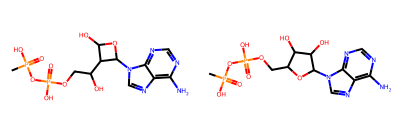

In [195]:
img, decompdiff_mol, sim_mol = try_pocket('5w2g_A')
img

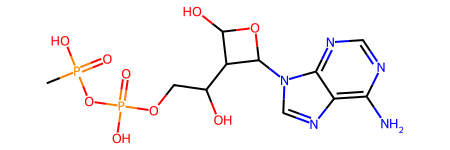

In [196]:
decompdiff_mol

In [197]:
molecule_to_pdf(decompdiff_mol, 'decomp_molecule', 300, 200)
molecule_to_pdf(sim_mol, 'decomp_similar_molecule', 300, 200)

In [198]:
from IPython.display import SVG, display

In [199]:
# for p in list(decomp_res.keys()):
#     img = try_pocket(p)
#     if img is not None:
#         display(img)

In [200]:
# pdb_id = '4f1m_A'

In [201]:
# idx_sort = [i for i in np.argsort(pharmaco_res[pdb_id]['novelty'])]
# i = 3

# pharmaco_mol = Chem.MolFromSmiles(pharmaco_res[pdb_id]['smiles'][idx_sort[i]])

# img = Draw.MolToImage(pharmaco_mol, size=(200, 133), thickness=0)
# img.save('figures/example_mols/pharmaco_molecule1.png')
# img

In [202]:
# smi = get_most_similar_compound(pharmaco_res[pdb_id]['smiles'][idx_sort[i]])
# sim_mol = Chem.MolFromSmiles(smi)
# img = Draw.MolToImage(sim_mol, size=(200, 133), thickness=0)
# img.save('figures/example_mols/pharmaco_similar_molecule1.png')
# img

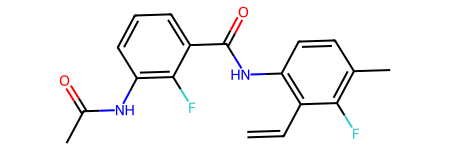

In [203]:
idx_sort = [i for i in np.argsort(pharmaco_res['5w2g_A']['novelty'])]
i = 2

pharmaco_mol = Chem.MolFromSmiles(pharmaco_res['5w2g_A']['smiles'][idx_sort[i]])

molecule_to_pdf(pharmaco_mol, 'pharmaco_molecule', 300, 200)
pharmaco_mol

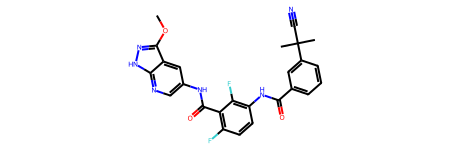

In [204]:
smi = get_most_similar_compound(pharmaco_res['5w2g_A']['smiles'][idx_sort[i]])
sim_mol = Chem.MolFromSmiles(smi)
molecule_to_pdf(sim_mol, 'pharmaco_similar_molecule', 300, 200)
sim_mol

In [205]:
print(f"novelty: {pharmaco_res['5w2g_A']['novelty'][idx_sort[i]]}")
print(f"qed: {pharmaco_res['5w2g_A']['qeds'][idx_sort[i]]}")
print(f"sa: {pharmaco_res['5w2g_A']['sas'][idx_sort[i]]}")
print(f"ds: {pharmaco_res['5w2g_A']['docking_scores'][idx_sort[i]]}")

novelty: 0.6304347826086957
qed: 0.8855077046292027
sa: 0.838068965237138
ds: -7.7
